# Modeling with Random Forest Classifier

In this notebook I continue to work on model iterations

Steps:
- ohe distircts and drop the municipality and ward ids (add them back later with feature engineering if time permits)
- Model iterarions for ensemble classification models. 
- run grid search for sampled data and find the best hyperparameters
- test out each iterations on validation set.
- finally run the models on the test set and pick the best performer.

In [ ]:
#imports
%load_ext autoreload
%autoreload 2

In [97]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import cleaning_functions as cfs
from src import preprocessing_functions as pfs
from src import modeling_functions as mfs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier 
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import recall_score, f1_score, make_scorer

Bringing in cleaned data 

In [3]:
df = cfs.cleaned_dataframe()

In [4]:
df.head()

,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,target
building_id,,,,,,,,,,,,,,,,,,,,,
120101000011,12,1207,120703,1,9,288,9,flat,other,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,2.0
120101000021,12,1207,120703,1,15,364,9,flat,other,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,3.0
120101000031,12,1207,120703,1,20,384,9,flat,other,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,1.0
120101000041,12,1207,120703,1,20,312,9,flat,other,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,1.0
120101000051,12,1207,120703,1,30,308,9,flat,other,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,1.0


Dropping `vdcmun_id` and `ward_id`

In [5]:
df = df.drop(['vdcmun_id', 'ward_id'], axis=1)

In [6]:
df.head()

,district_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,target
building_id,,,,,,,,,,,,,,,,,,,,,
120101000011,12,1,9,288,9,flat,other,bamboo_or_timber_light_roof,mud,not_applicable,...,0,0,0,0,0,0,0,0,0,2.0
120101000021,12,1,15,364,9,flat,other,bamboo_or_timber_light_roof,mud,not_applicable,...,0,0,0,0,0,0,0,0,0,3.0
120101000031,12,1,20,384,9,flat,other,bamboo_or_timber_light_roof,mud,not_applicable,...,0,0,0,0,0,0,0,0,0,1.0
120101000041,12,1,20,312,9,flat,other,bamboo_or_timber_light_roof,mud,not_applicable,...,0,0,0,0,0,0,0,0,0,1.0
120101000051,12,1,30,308,9,flat,other,bamboo_or_timber_light_roof,mud,not_applicable,...,0,0,0,0,0,0,0,0,0,1.0


In [7]:
#create target and feature dataframes 
y = df['target']
X = df.drop('target', axis=1)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2015, test_size = .2)

#train validation split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state = 2015, test_size = .25)

#stratified sampling to have equal representation of classes
rus = RandomUnderSampler(random_state=2015)
X_tr_res, y_tr_res = rus.fit_resample(X_tr, y_tr)

#One Hot encode all categorical features land_surface_condition,foundation_type, roof_type, ground_floor_type, other_floor_type
X_tr_res, X_val, X_test = pfs.ohe_train_and_test_features(X_tr_res, X_val, X_test)

#One hot encode district_id
X_tr_res, X_val, X_test = pfs.ohe_train_val_test_geos(X_tr_res, X_val, X_test)

In [8]:
X_tr_res.head()

,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,...,20,21,22,23,24,28,29,30,31,36
0,1,52,150,8,0,1,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,15,186,8,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,7,392,12,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2,17,496,12,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2,24,305,18,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Starting with a Decision tree to build our first model and see where our most greediest splits occur.

In [9]:
dt = DecisionTreeClassifier(random_state=2015)
dt.fit(X_tr_res, y_tr_res)

DecisionTreeClassifier(random_state=2015)

In [10]:
from sklearn.metrics import classification_report

In [11]:
print(classification_report(y_tr_res, dt.predict(X_tr_res)))

              precision    recall  f1-score   support

         1.0       0.98      1.00      0.99     81857
         2.0       0.98      0.99      0.99     81857
         3.0       1.00      0.98      0.99     81857

    accuracy                           0.99    245571
   macro avg       0.99      0.99      0.99    245571
weighted avg       0.99      0.99      0.99    245571



Just to gain an idea of where the most greediest splits occur

In [12]:
from sklearn.tree import plot_tree

[Text(558.0, 665.91, 'has_superstructure_mud_mortar_stone <= 0.5\ngini = 0.667\nsamples = 245571\nvalue = [81857, 81857, 81857]'),
 Text(279.0, 475.65, 'rc <= 0.5\ngini = 0.485\nsamples = 67396\nvalue = [45175, 16283, 5938]'),
 Text(139.5, 285.39, '31 <= 0.5\ngini = 0.586\nsamples = 35509\nvalue = [19324, 11017, 5168]'),
 Text(69.75, 95.13, '\n  (...)  \n'),
 Text(209.25, 95.13, '\n  (...)  \n'),
 Text(418.5, 285.39, 'rc <= 0.5\ngini = 0.315\nsamples = 31887\nvalue = [25851, 5266, 770]'),
 Text(348.75, 95.13, '\n  (...)  \n'),
 Text(488.25, 95.13, '\n  (...)  \n'),
 Text(837.0, 475.65, '23 <= 0.5\ngini = 0.641\nsamples = 178175\nvalue = [36682, 65574, 75919]'),
 Text(697.5, 285.39, '28 <= 0.5\ngini = 0.648\nsamples = 162469\nvalue = [36316, 64320, 61833]'),
 Text(627.75, 95.13, '\n  (...)  \n'),
 Text(767.25, 95.13, '\n  (...)  \n'),
 Text(976.5, 285.39, 'rcc_or_rb_or_rbc <= 0.5\ngini = 0.189\nsamples = 15706\nvalue = [366, 1254, 14086]'),
 Text(906.75, 95.13, '\n  (...)  \n'),
 Text(1

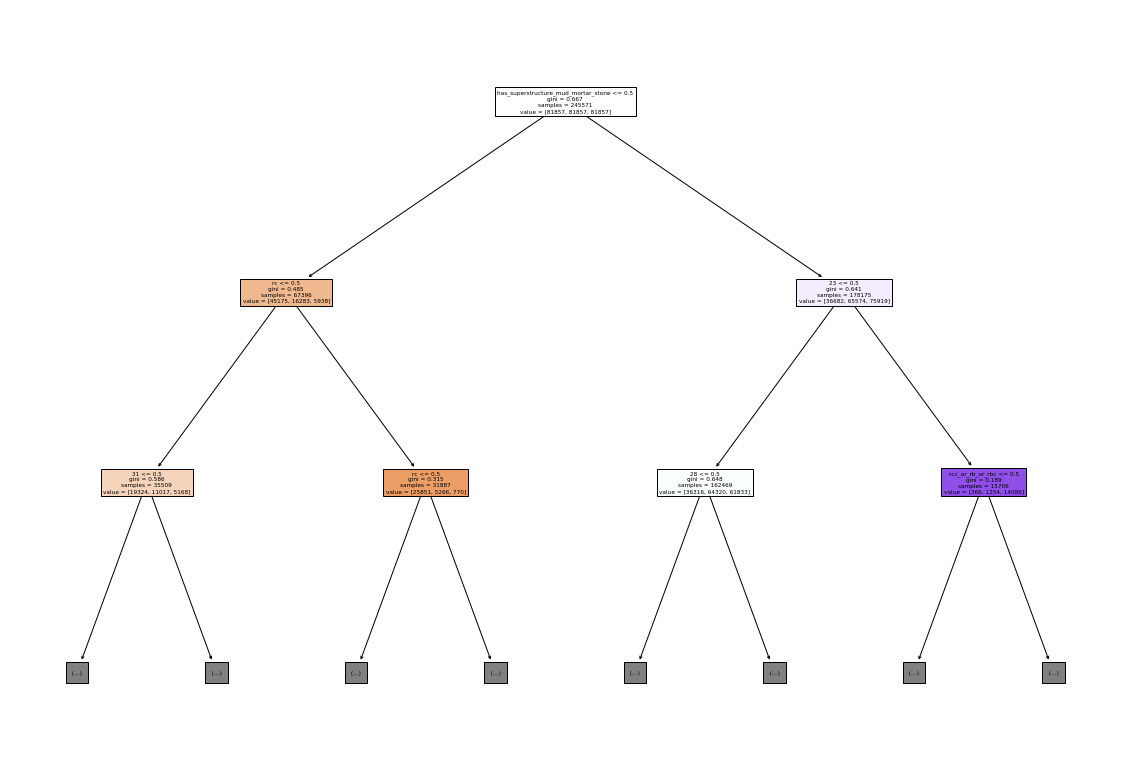

In [13]:
fig, ax = plt.subplots(figsize=(20,14))
plot_tree(dt, feature_names=X_tr_res.columns, max_depth=2, filled=True, ax=ax)

Identifying our most important features for making classification 

In [14]:
important_features = list(zip(X_tr_res.columns, dt.feature_importances_))
sorted_features = sorted(important_features, key=lambda x: x[1])

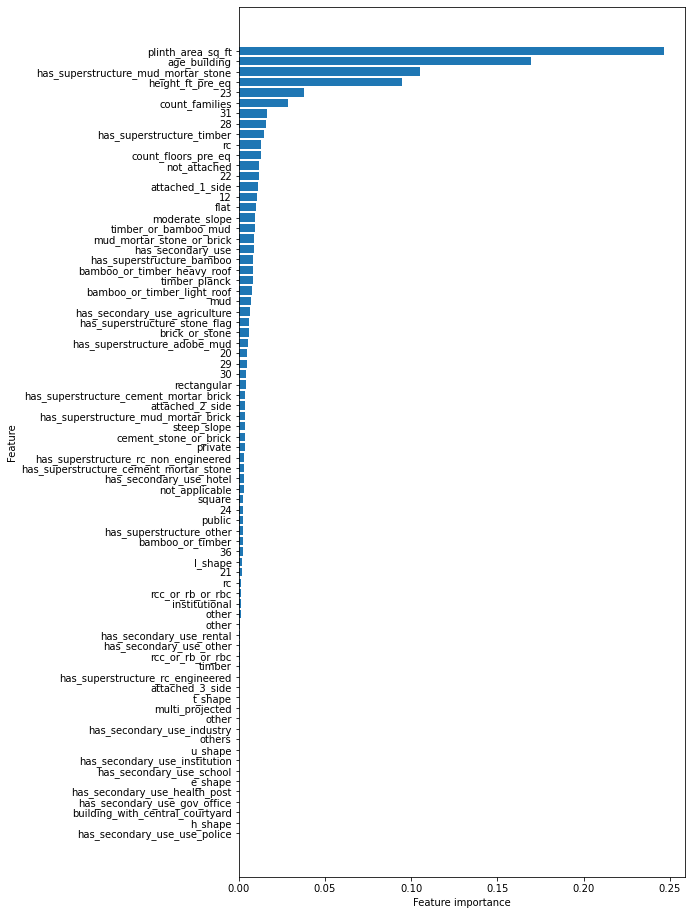

In [15]:
importance = []
feature_names = []
plt.figure(figsize=(8, 16))
n_features = X_tr_res.shape[1]
for i in sorted_features:
    feature_names.append(i[0])
    importance.append(i[1])
    
plt.barh(range(n_features), importance)
plt.yticks(np.arange(n_features), feature_names)
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

We notice that the plinth area and building age are given importance in our first model. This could be due to the value of these variables being large, We will scale our numeric data and redo our baseline model before we test on our validation set.

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
X_train_scaled = X_tr_res.copy()
col_names = ['count_floors_pre_eq', 'count_families', 'age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq']
features = X_train_scaled[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

X_train_scaled[col_names] = features
X_train_scaled.head()

,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,...,20,21,22,23,24,28,29,30,31,36
0,-1.536583,0.442693,-1.098342,-1.386090,0,1,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.536583,-0.120057,-0.952638,-1.386090,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.047621,-0.241732,-0.118883,-0.686274,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.047621,-0.089638,0.302041,-0.686274,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.047621,0.016828,-0.471003,0.363450,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

features = X_val_scaled[col_names]
features = scaler.transform(features.values)
X_val_scaled[col_names] = features
features = X_test_scaled[col_names]
features = scaler.transform(features.values)
X_test_scaled[col_names] = features


In [19]:
X_val_scaled.head()

,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,...,20,21,22,23,24,28,29,30,31,36
building_id,,,,,,,,,,,,,,,,,,,,,
366409000591,-0.047621,0.108085,0.399178,0.538404,0,1,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
302306002231,-0.047621,-0.256942,1.734804,-0.686274,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
283907000681,-0.047621,0.488321,-0.248399,1.063266,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
290508020311,1.441341,-0.226523,-0.005558,1.588128,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
201404000311,-0.047621,-0.120057,-0.491240,0.713358,0,1,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X_test_scaled.head()

,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,...,20,21,22,23,24,28,29,30,31,36
building_id,,,,,,,,,,,,,,,,,,,,,
231604000321,1.441341,-0.180895,-0.050078,0.888312,0,1,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
362809000701,-1.536583,-0.120057,-0.337440,-0.511320,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
202807000381,-0.047621,-0.196104,0.107768,-0.336366,0,1,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
230209001241,1.441341,0.260179,-0.248399,0.888312,0,1,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
202604001902,-0.047621,-0.302570,-0.713844,-0.161412,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
dt2 = DecisionTreeClassifier(random_state=2015)
dt2.fit(X_train_scaled, y_tr_res)

DecisionTreeClassifier(random_state=2015)

In [22]:
print(classification_report(y_tr_res, dt2.predict(X_train_scaled)))

              precision    recall  f1-score   support

         1.0       0.98      1.00      0.99     81857
         2.0       0.98      0.99      0.99     81857
         3.0       1.00      0.98      0.99     81857

    accuracy                           0.99    245571
   macro avg       0.99      0.99      0.99    245571
weighted avg       0.99      0.99      0.99    245571



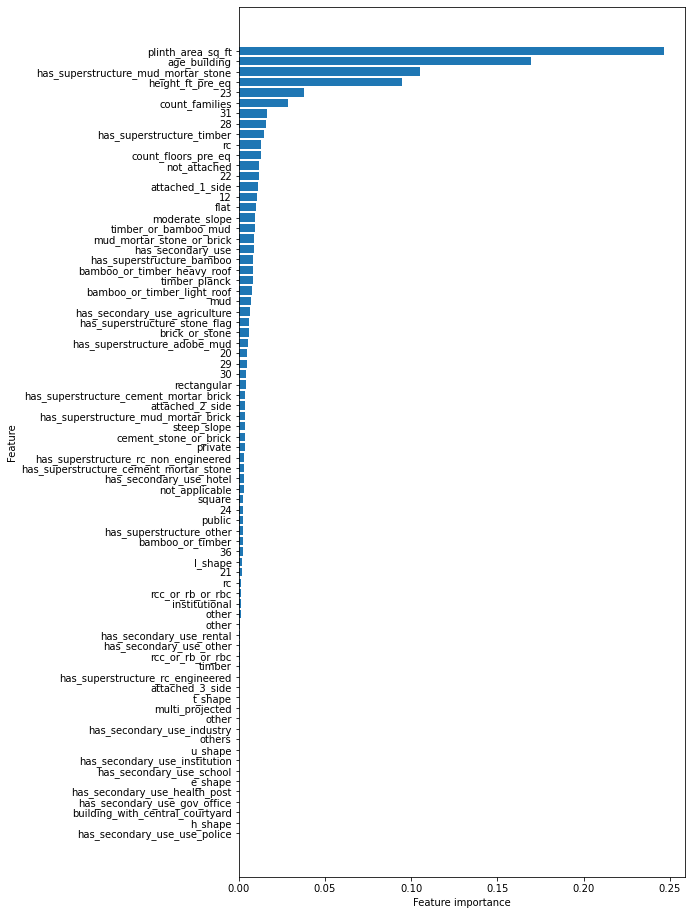

In [23]:
important_features = list(zip(X_train_scaled.columns, dt2.feature_importances_))
sorted_features = sorted(important_features, key=lambda x: x[1])
importance = []
feature_names = []

for i in sorted_features:
    feature_names.append(i[0])
    importance.append(i[1])
    
plt.figure(figsize=(8, 16))
n_features = X_train_scaled.shape[1]    
plt.barh(range(n_features), importance)
plt.yticks(np.arange(n_features), feature_names)
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

scaling the numeric columns didn't change anything. we'll go ahead and try out our validation set and see how high the variance is between the training and validation set (expecting it to be high since the model is definitely overfitting the training set at the moment)

In [24]:
print(classification_report(y_val, dt.predict(X_val)))
print(classification_report(y_val, dt2.predict(X_val_scaled)))

              precision    recall  f1-score   support

         1.0       0.51      0.60      0.55     33118
         2.0       0.26      0.45      0.33     27409
         3.0       0.82      0.59      0.68     91892

    accuracy                           0.57    152419
   macro avg       0.53      0.55      0.52    152419
weighted avg       0.65      0.57      0.59    152419

              precision    recall  f1-score   support

         1.0       0.51      0.60      0.55     33118
         2.0       0.26      0.45      0.33     27409
         3.0       0.82      0.59      0.68     91892

    accuracy                           0.57    152419
   macro avg       0.53      0.55      0.52    152419
weighted avg       0.65      0.57      0.59    152419



As guessed our model failed to perform well on our validation set. Let's fix this with some regularization, hyperparameter tuning and using ensemble methods.

For future comprisons, our baseline model gives us a recall score for class 3 of 59% (on validation set).

### Ensemble Methods for Classification
Game plan:
- Start with a basic Vanilla classifier with cross validation
- Test out the model on validation set
- sample the training data and run grid search to find hyperprameters
- Run models on the entire training set with identified hyperparameters.
- compare train and validation score
- Identify the best model and then score the test data

### RandomForestClassifier

In [25]:
recall3 = mfs.scorer_recall3()
f13 = mfs.scorer_f13()

In [73]:
rfc1 = RandomForestClassifier(random_state=2015)
print('Racall for class 3 : ', cross_val_score(rfc1, X_train_scaled, y_tr_res, cv=5, scoring=recall3))

Racall for class 3 :  [0.65434889 0.66575041 0.65139576 0.65927555 0.65960176]


Low variance observed between the folds and improvement from 59% recall score from our baseline. However, at around 65% the recall score is quite low still. 

In [74]:
rfc1.fit(X_train_scaled, y_tr_res)

RandomForestClassifier(random_state=2015)

In [101]:
print('Recall Score Class 3 Validation set: ', recall_score(y_val, rfc1.predict(X_val_scaled), average=None)[2])

Recall Score Class 3 Validation set:  0.6602533408784225


In [76]:
print('Recall Score Class 3 Train set: ', recall_score(y_tr_res, rfc1.predict(X_train_scaled), average=None)[2])

Recall Score Class 3 Train set:  0.9892495449381238


Our model is currently overfitting our training data and fails to be generalized on the validation set resulting in high variance. 

We'll resample the training data and run a grid search to see if we can improve this. (we do this only because of computational complexity and runtime issue)

In [78]:
combined_train = pd.concat([X_train_scaled, y_tr_res], axis=1)
smaller_train = combined_train.sample(frac=0.4, random_state=2015)
smaller_train.target.value_counts(normalize=True)

3.0    0.334742
2.0    0.333764
1.0    0.331494
Name: target, dtype: float64

In [79]:
X_for_gs = smaller_train.drop('target', axis=1)
y_for_gs = smaller_train['target']

In [36]:
param_grid = {
    'n_estimators': [200, 300, 450],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 50, 30]
}

In [37]:
rf = RandomForestClassifier(random_state=2015)
gs = GridSearchCV(rf, param_grid=param_grid, scoring=recall3, cv=3)

In [38]:
gs.fit(X_for_gs, y_for_gs)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=2015),
             param_grid={'max_depth': [None, 50, 30],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300, 450]},
             scoring=make_scorer(recall_score_class3))

In [39]:
gs.best_params_

{'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 200}

Note: Our best params identified are constrained by our choice of grid as well as resampled dataset. There is room for improvement here.

`best_params` = {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 200}

In [40]:
gs.best_estimator_

RandomForestClassifier(max_depth=30, max_features='sqrt', n_estimators=200,
                       random_state=2015)

In [41]:
rfc2 = RandomForestClassifier(max_depth=30, max_features='sqrt',
                              n_estimators=200,random_state=2015)

rfc2.fit(X_train_scaled, y_tr_res)

In [42]:
print(recall_score(y_val, rfc2.predict(X_val_scaled), average=None)[2])

0.6788294954947112


In [72]:
print(classification_report(y_tr_res, rfc2.predict(X_train_scaled)))

              precision    recall  f1-score   support

         1.0       0.93      0.88      0.90     81857
         2.0       0.84      0.86      0.85     81857
         3.0       0.86      0.89      0.88     81857

    accuracy                           0.87    245571
   macro avg       0.88      0.87      0.88    245571
weighted avg       0.88      0.87      0.88    245571



In [43]:
print(classification_report(y_val, rfc2.predict(X_val_scaled)))

              precision    recall  f1-score   support

         1.0       0.65      0.69      0.67     33118
         2.0       0.32      0.53      0.40     27409
         3.0       0.87      0.68      0.76     91892

    accuracy                           0.65    152419
   macro avg       0.61      0.63      0.61    152419
weighted avg       0.72      0.65      0.68    152419



Tweaking the hyperparameters with the aid of grid search helped improve our bias and variance only slightly, We are still overfitting the training data and missing our mark on the validation set. 

We'll try tweaking the hyperparameters to make the model more generalizable

In [83]:
rfc3 = RandomForestClassifier(max_depth=12, max_features='sqrt',
                              n_estimators=150,random_state=2015)

rfc3.fit(X_train_scaled, y_tr_res)

RandomForestClassifier(max_depth=12, max_features='sqrt', n_estimators=150,
                       random_state=2015)

In [84]:
print('Recall Score Class 3 on Validation data: ', recall_score(y_val, rfc3.predict(X_val_scaled), average=None)[2])

Recall Score Class 3 on Validation data:  0.6725177382144256


In [86]:
print('Recall Score Class 3 on Train data: ', recall_score(y_tr_res, rfc3.predict(X_train_scaled), average=None)[2])

Recall Score Class 3 on Train data:  0.6827516278387921


Our model has become more generalizable with these changes (low variance) however, our bias is still high. I'm curious to see if further tweaking can improve the current bias (off by 32% currently)

In [88]:
rfc4 = RandomForestClassifier(max_depth=15, max_features='sqrt',
                              n_estimators=180,random_state=2015)
rfc4.fit(X_train_scaled, y_tr_res)

RandomForestClassifier(max_depth=15, max_features='sqrt', n_estimators=180,
                       random_state=2015)

In [89]:
print('Recall Score Class 3 on Validation data: ', recall_score(y_val, rfc4.predict(X_val_scaled), average=None)[2])

Recall Score Class 3 on Validation data:  0.6579571671092151


In [90]:
print('Recall Score Class 3 on Train data: ', recall_score(y_tr_res, rfc4.predict(X_train_scaled), average=None)[2])

Recall Score Class 3 on Train data:  0.6809680296126172


Again this model does not overfit the training data which is great, but its performance isn't spectacular either. 

We will stop our iterations here for now and go with our **current best performer rfc3**.

In [98]:
print('Classification Report for rfc3, Test Data','\n',
      '======================================================','\n',
      classification_report(y_test, rfc3.predict(X_test_scaled)))

Classification Report for rfc3, Test Data 
               precision    recall  f1-score   support

         1.0       0.66      0.67      0.67     33245
         2.0       0.29      0.49      0.37     27146
         3.0       0.85      0.67      0.75     92028

    accuracy                           0.64    152419
   macro avg       0.60      0.61      0.59    152419
weighted avg       0.71      0.64      0.66    152419



In [99]:
print('Classification Report for rfc3, Validation Data','\n',
      '======================================================','\n',
      classification_report(y_val, rfc3.predict(X_val_scaled)))

Classification Report for rfc3, Validation Data 
               precision    recall  f1-score   support

         1.0       0.66      0.67      0.66     33118
         2.0       0.30      0.49      0.37     27409
         3.0       0.85      0.67      0.75     91892

    accuracy                           0.64    152419
   macro avg       0.60      0.61      0.59    152419
weighted avg       0.71      0.64      0.66    152419



In [100]:
print('Classification Report for rfc3, Training Data','\n',
      '======================================================','\n',
      classification_report(y_tr_res, rfc3.predict(X_train_scaled)))

Classification Report for rfc3, Training Data 
               precision    recall  f1-score   support

         1.0       0.72      0.68      0.70     81857
         2.0       0.51      0.51      0.51     81857
         3.0       0.64      0.68      0.66     81857

    accuracy                           0.62    245571
   macro avg       0.62      0.62      0.62    245571
weighted avg       0.62      0.62      0.62    245571



### GradientBoostingClassifier

In [44]:
gbc1 = GradientBoostingClassifier(random_state=2015)
print('Racall for class 3 : ', cross_val_score(gbc1, X_train_scaled, y_tr_res, cv=5, scoring=recall3))

Racall for class 3 :  [0.60707305 0.62592389 0.61608943 0.62671798 0.61825067]


In [46]:
import xgboost

GradientBoosting continued in the next notebook